# Evaluating Transformer-based Models for Text classification on the Cola Dataset

## Table of Contents
* [EDA](##EDA)
    * [Distribution of Labels](###Distribution_of_Labels¶)
    * [Distribution of Sentence Lengths](###Distribution_of_Sentence_Lengths¶)
    * [Class Distribution](###Class_Distribution¶)
    * [Word Cloud](###Word_Cloud¶)
* [Models](#Models)
    * [BERT](##BERT)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Distilbert](##DistilbertT)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Electra](##Electra)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Roberta](##Roberta)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
    * [Albert](##Albert)
        * [Data Processing](##Data_Processing)
        * [Train Model](##Train-Model)
        * [Prediction](###Prediction)
* [Comparision](##Comparision)
    * [Accuracy Comparison](###Accuracy_Comparison)
    * [F1, Precision, and Recall Comparison](###F1,_Precision,_and_Recall_Comparison)
    * [Loss Comparison](###Loss_Comparison)


## EDA

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd

from sklearn.metrics import accuracy_score

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU available:")
    print(torch.cuda.get_device_name(0))  # This will print the name of the first GPU
else:
    print("No GPU available.")


GPU available:
NVIDIA GeForce RTX 3090


In [ ]:
# Load the dataset
dataset = load_dataset("glue", "cola")

Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

### Distribution of Labels

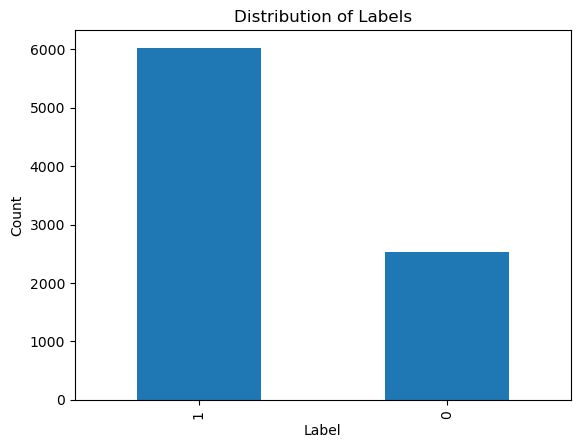

In [ ]:
# Get the train split
import matplotlib.pyplot as plt
train_dataset = dataset["train"]


# Convert the train split to a pandas DataFrame
df = pd.DataFrame(train_dataset)

# Distribution of labels
label_counts = df["label"].value_counts()
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

### Distribution of Sentence Lengths

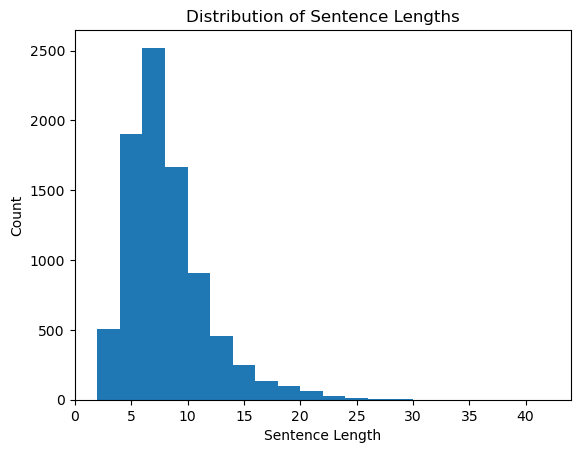

In [ ]:
# Sentence length analysis
df["sentence_length"] = df["sentence"].apply(lambda x: len(x.split()))
plt.hist(df["sentence_length"], bins=20)
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.title("Distribution of Sentence Lengths")
plt.show()

### Class Distribution

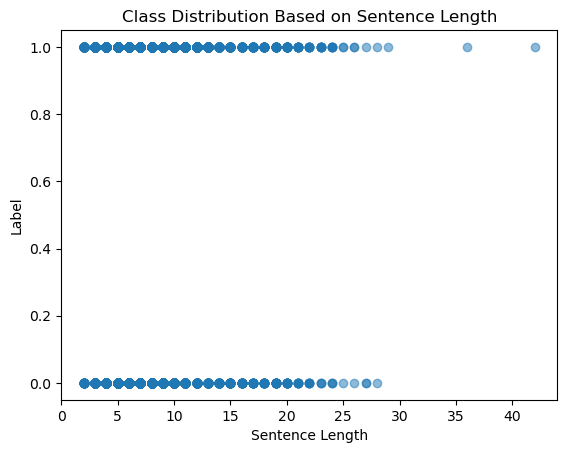

In [ ]:
# Class distribution based on sentence length
plt.scatter(df["sentence_length"], df["label"], alpha=0.5)
plt.xlabel("Sentence Length")
plt.ylabel("Label")
plt.title("Class Distribution Based on Sentence Length")
plt.show()

### Word Cloud

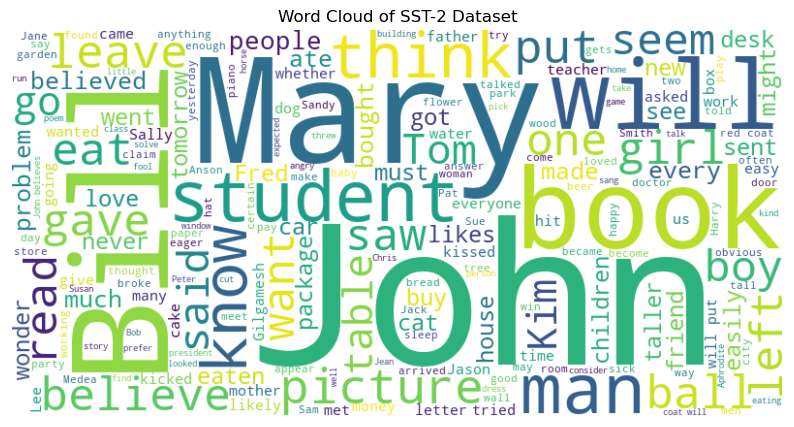

In [ ]:
from wordcloud import WordCloud

# Concatenate all sentences into a single string
all_sentences = " ".join(df["sentence"].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_sentences)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of SST-2 Dataset")
plt.show()


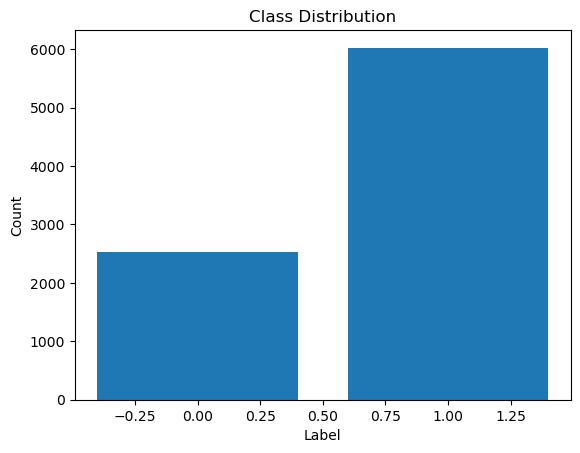

In [ ]:
label_counts = df["label"].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


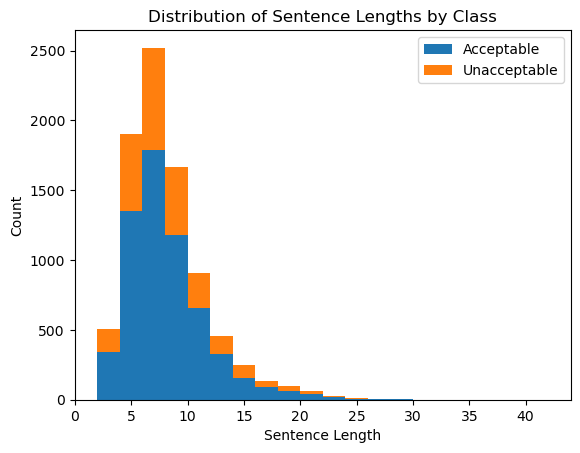

In [ ]:
positive_sentences = df[df["label"] == 1]["sentence_length"]
negative_sentences = df[df["label"] == 0]["sentence_length"]

plt.hist([positive_sentences, negative_sentences], bins=20, stacked=True, label=["Acceptable", "Unacceptable"])
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.title("Distribution of Sentence Lengths by Class")
plt.legend()
plt.show()


# Models

## BERT
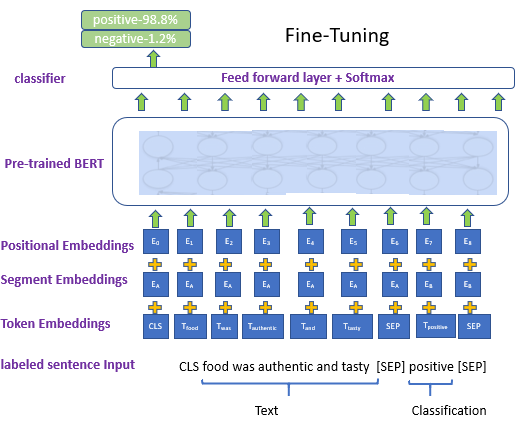

## Data Processing

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Loading cached processed dataset at C:\Users\Kowsher\.cache\huggingface\datasets\glue\cola\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-ff3a884b7d795a6b.arrow
Loading cached processed dataset at C:\Users\Kowsher\.cache\huggingface\datasets\glue\cola\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-11afbefd5c86d3e7.arrow
Loading cached processed dataset at C:\Users\Kowsher\.cache\huggingface\datasets\glue\cola\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-0b3a2cfb640c3867.arrow


In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(tokenized_dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(tokenized_dataset["train"]) * train_size), len(tokenized_dataset["train"])))



## Train Model

In [ ]:
# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =50,
    logging_steps=50,
    num_train_epochs=1,
    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Start the training
trainer.train()

C:\Users\Kowsher\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.254400,0.718512
100,0.207200,0.614445
150,0.186700,0.647328
200,0.230100,0.504690
250,0.375600,0.463223


TrainOutput(global_step=264, training_loss=0.25749850634372595, metrics={'train_runtime': 214.538, 'train_samples_per_second': 31.882, 'train_steps_per_second': 1.231, 'total_flos': 1799679618662400.0, 'train_loss': 0.25749850634372595, 'epoch': 1.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']


In [ ]:

from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.8120805369127517
f1_score:  0.8698539176626826
precision_score:  0.8343949044585988
recall_score:  0.9084604715672677


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_bert_cola.csv', index=False)

## Distilbert
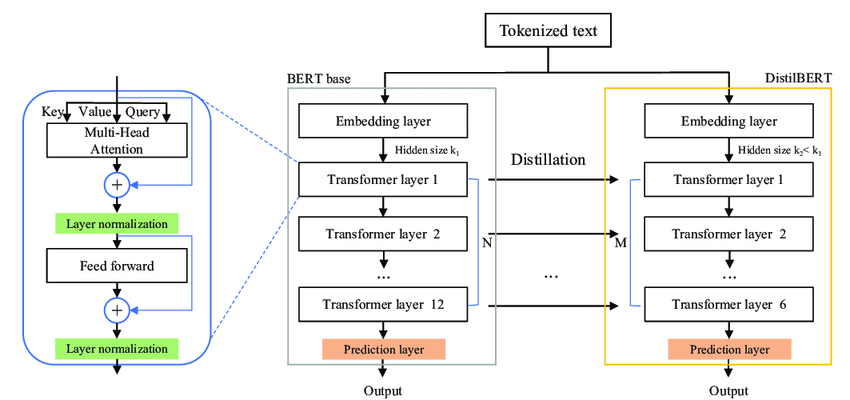

## Data Processing

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("glue", "cola")

# Load the DistilBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Kowsher\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kowsher\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=3,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



C:\Users\Kowsher\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.602700,0.529413,0.757452
100,0.545100,0.498155,0.741672
150,0.514100,0.487178,0.774985
200,0.506300,0.463428,0.789597
250,0.526900,0.457000,0.797779
300,0.365400,0.506240,0.795441
350,0.316500,0.480714,0.808299
400,0.299700,0.500355,0.797195
450,0.305000,0.519156,0.797779
500,0.292600,0.501102,0.803624


TrainOutput(global_step=792, training_loss=0.3372804390059577, metrics={'train_runtime': 332.9045, 'train_samples_per_second': 61.639, 'train_steps_per_second': 2.379, 'total_flos': 2718231020421120.0, 'train_loss': 0.3372804390059577, 'epoch': 3.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']


In [ ]:


from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.785234899328859
f1_score:  0.851261620185923
precision_score:  0.8165605095541402
recall_score:  0.8890429958391124


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_distilbert_cola.csv', index=False)

In [ ]:
df

,Truth value,Predict value
0,1,1
1,1,1
2,1,1
3,1,1
4,0,1
...,...,...
1038,1,1
1039,1,1
1040,0,1
1041,1,1


## Electra
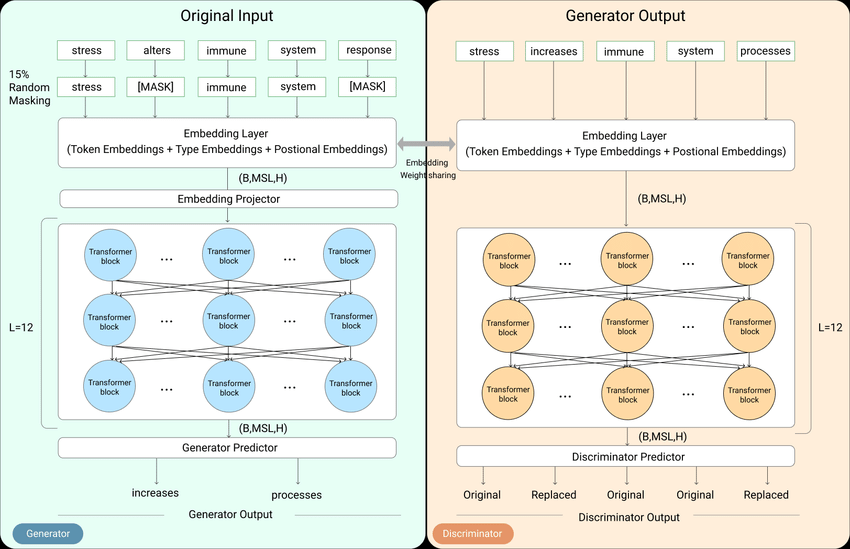

## Data Processing

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("glue", "cola")

# Load the ELECTRA tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=2)


Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=3,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=2,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



C:\Users\Kowsher\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.489700,0.433246,0.801870
100,0.431600,0.402718,0.804793
150,0.391900,0.391808,0.827002
200,0.378600,0.415810,0.804793
250,0.430200,0.372005,0.841029
300,0.254000,0.427154,0.833431
350,0.222000,0.483858,0.822911
400,0.206700,0.495648,0.819988
450,0.203900,0.506416,0.815313
500,0.188000,0.501011,0.818819


TrainOutput(global_step=792, training_loss=0.2502445837463995, metrics={'train_runtime': 640.8016, 'train_samples_per_second': 32.022, 'train_steps_per_second': 1.236, 'total_flos': 5399038855987200.0, 'train_loss': 0.2502445837463995, 'epoch': 3.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.8446788111217641
f1_score:  0.892
precision_score:  0.858793324775353
recall_score:  0.9278779472954231


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_electra_cola.csv', index=False)

In [ ]:
df

,Truth value,Predict value
0,1,1
1,1,1
2,1,1
3,1,1
4,0,1
...,...,...
1038,1,1
1039,1,1
1040,0,1
1041,1,1


## Roberta
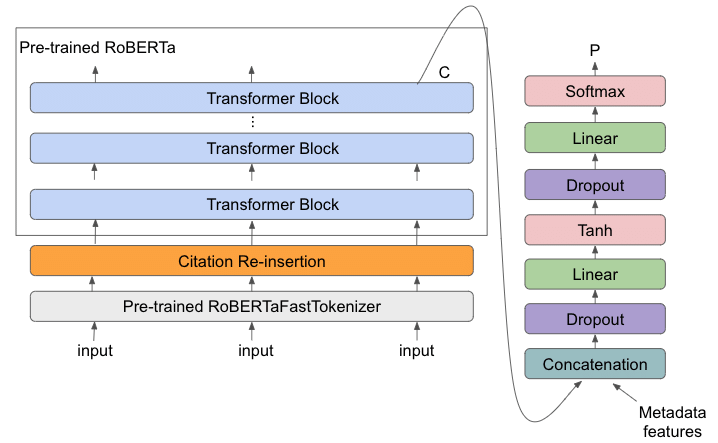

## Data Processing

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("glue", "cola")

# Load the RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=3,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



C:\Users\Kowsher\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.606300,0.507956,0.796610
100,0.549800,0.464187,0.787843
150,0.505400,0.428545,0.802455
200,0.475000,0.441599,0.814144
250,0.509700,0.405495,0.818235
300,0.391700,0.436353,0.826417
350,0.365700,0.405408,0.838691
400,0.346700,0.425929,0.844535
450,0.305400,0.449169,0.842782
500,0.319400,0.413998,0.846873


TrainOutput(global_step=792, training_loss=0.35416543002080436, metrics={'train_runtime': 640.9112, 'train_samples_per_second': 32.017, 'train_steps_per_second': 1.236, 'total_flos': 5399038855987200.0, 'train_loss': 0.35416543002080436, 'epoch': 3.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.8216682646212847
f1_score:  0.8806161745827985
precision_score:  0.8195937873357229
recall_score:  0.9514563106796117


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_roberta_cola.csv', index=False)

In [ ]:
df

,Truth value,Predict value
0,1,1
1,1,1
2,1,1
3,1,1
4,0,1
...,...,...
1038,1,1
1039,1,1
1040,0,1
1041,1,1


## Albert
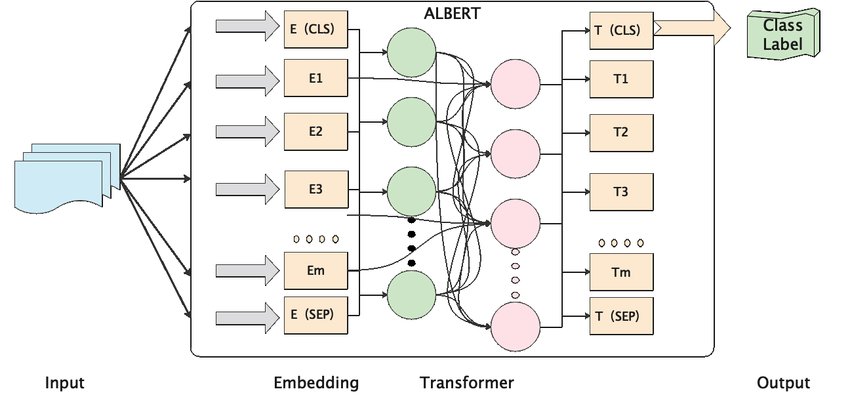

## Data Processing

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the SST-2 dataset
dataset = load_dataset("glue", "cola")

# Load the RoBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)


Found cached dataset glue (C:/Users/Kowsher/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the sentences and add special tokens
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length")

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into training and testing subsets
train_size = 0.8
train_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size)))
val_dataset = tokenized_dataset["train"].select(range(int(len(dataset["train"]) * train_size), len(dataset["train"])))

## Train Model

In [ ]:
# Define the training and evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output_dir",  # Directory where the model checkpoints and logs will be saved # Evaluate the model after each epoch
    evaluation_strategy = "steps",
    num_train_epochs=1,
    per_device_train_batch_size=26,
    per_device_eval_batch_size=26,
    save_total_limit=1,
    eval_steps =50,
    logging_steps=50,

    logging_dir="./logs",  # Directory where the training logs will be saved
    load_best_model_at_end=True,
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()



Step,Training Loss,Validation Loss,Accuracy
50,0.477800,0.472794,0.770527
100,0.473300,0.472847,0.788344
150,0.388900,0.362064,0.859540
200,0.388800,0.385651,0.866964
250,0.354900,0.416559,0.863400
300,0.318100,0.317248,0.870824
350,0.315300,0.315692,0.867558
400,0.347900,0.343221,0.879362
450,0.318500,0.282151,0.887899
500,0.305100,0.281928,0.885078


TrainOutput(global_step=2073, training_loss=0.2722006396170808, metrics={'train_runtime': 6213.1665, 'train_samples_per_second': 8.672, 'train_steps_per_second': 0.334, 'total_flos': 1287605824727040.0, 'train_loss': 0.2722006396170808, 'epoch': 1.0})

## Prediction

In [ ]:
test_data = tokenized_dataset["validation"]
test_input = test_data['input_ids']
y_true = test_data['label']




from torch.utils.data import DataLoader

# Create a DataLoader for batch processing
batch_size = 16  # Adjust batch size based on available memory
test_loader = DataLoader(test_data, batch_size=batch_size)

ypred = []
trainer.model.eval()

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(trainer.model.device)
    attention_mask = batch['attention_mask'].to(trainer.model.device)

    with torch.no_grad():
        outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)

    pred_labels = outputs.logits.argmax(dim=1).tolist()
    ypred.extend(pred_labels)




  0%|          | 0/55 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("accuracy_score: ", accuracy_score(y_true, ypred))
print("f1_score: ", f1_score(y_true, ypred))
print("precision_score: ", precision_score(y_true, ypred))
print("recall_score: ", recall_score(y_true, ypred))

accuracy_score:  0.8979357798165137
f1_score:  0.9001122334455668
precision_score:  0.8970917225950783
recall_score:  0.9031531531531531


In [ ]:
import pandas as pd



# Convert lists to a DataFrame
result = {'Truth value': y_true, 'Predict value': ypred}
df = pd.DataFrame(result)

# Save the DataFrame to a CSV file
df.to_csv('predictions_albert_cola.csv', index=False)

## Comparision

### Accuracy Comparison

In [ ]:
import matplotlib.pyplot as plt

models = ["BERT", "DistilBERT", "ELECTRA", "RoBERTa", "ALBERT"]
accuracy_val = [0.8220, 0.802, 0.835, 0.857,0.925]
accuracy_test =[0.8120, 0.785, 0.844,0.821, 0.897]
f1_score =     [0.869, 0.851, 0.892, 0.880, 0.900]
precision =    [0.834, 0.816, 0.858, 0.819, 0.897]
recall =       [0.908, 0.889, 0.927, 0.951, 0.878]
loss_val =     [0.463, 0.614, 0.578, 0.489, 0.903]
loss_train =   [0.375, 0.182, 0.384, 0.222, 0.215]



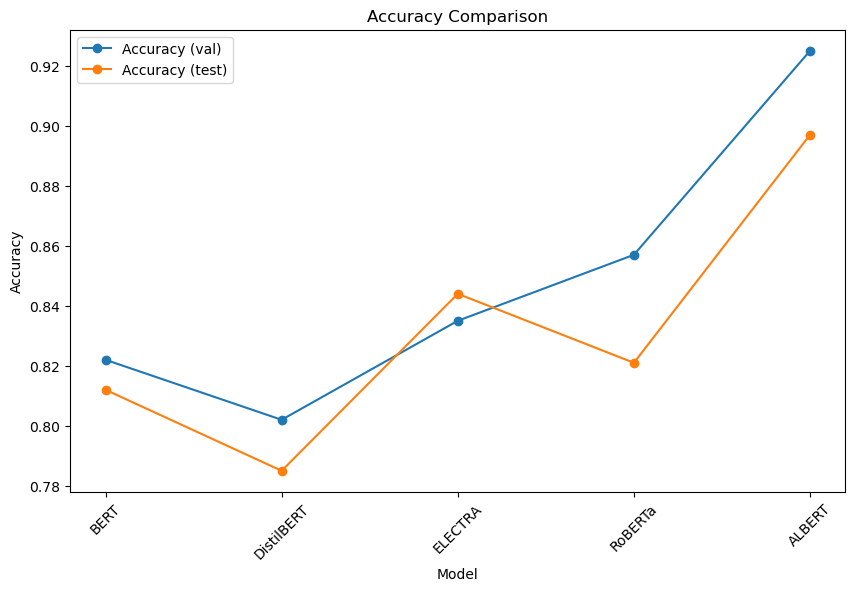

In [ ]:
# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_val, marker="o", label="Accuracy (val)")
plt.plot(models, accuracy_test, marker="o", label="Accuracy (test)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()




### F1, Precision, and Recall Comparison

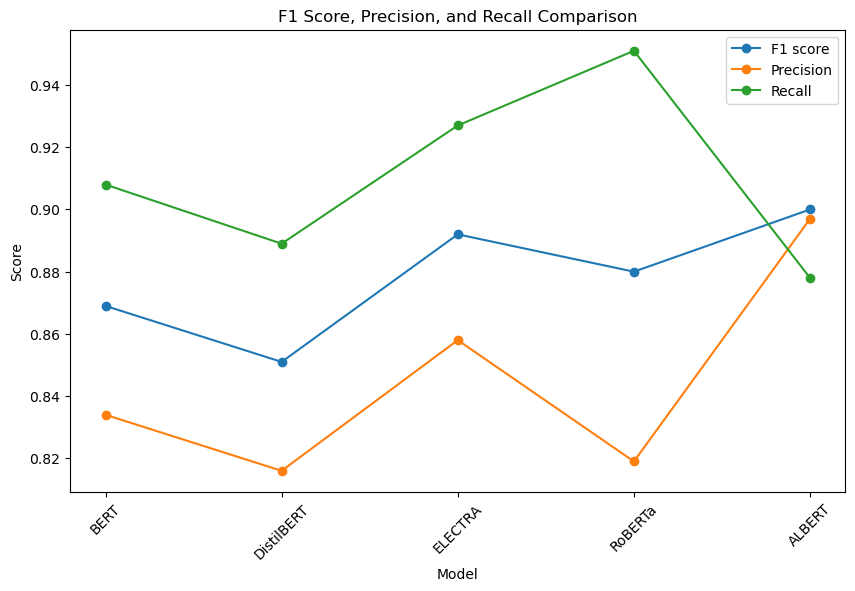

In [ ]:
# Plotting F1 score, precision, and recall
plt.figure(figsize=(10, 6))
plt.plot(models, f1_score, marker="o", label="F1 score")
plt.plot(models, precision, marker="o", label="Precision")
plt.plot(models, recall, marker="o", label="Recall")
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("F1 Score, Precision, and Recall Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()



### Loss Comparison

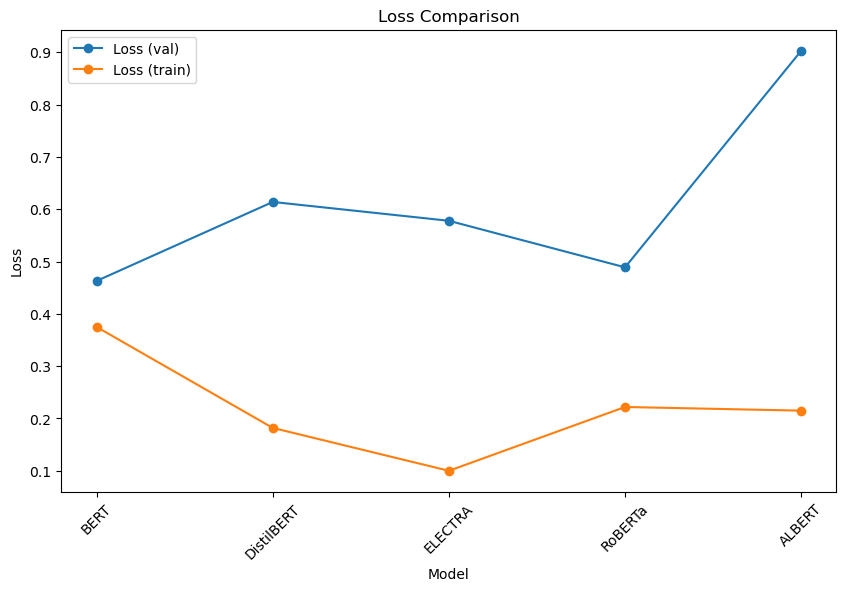

In [ ]:
# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(models, loss_val, marker="o", label="Loss (val)")
plt.plot(models, loss_train, marker="o", label="Loss (train)")
plt.xlabel("Model")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.show()